In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.model_selection import train_test_split

# tf version check
print(tf.__version__)

2.1.0


# Loading the Data

In [2]:
raw_jan19 = pd.read_csv("../data/Jan_2019_ontime.csv")
raw_jan20 = pd.read_csv("../data/Jan_2020_ontime.csv")
df = pd.concat([raw_jan19, raw_jan20], ignore_index=True)
df = df.drop(columns = 'Unnamed: 21') # unnecessary

# number of rows in the combined dataframe
nrows_org = df.shape[0]
nrows_org

1191331

# Cleaning the Data

Does this data have any missing values?

In [3]:
df.isna().sum()

DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                  3241
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                 23016
DEP_DEL15                23054
DEP_TIME_BLK                 0
ARR_TIME                 24136
ARR_DEL15                26100
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
dtype: int64

There are several rows with missing values, so let's clean that up and remove them.

In [4]:
df = df.dropna()
nrows_rm_na = df.shape[0]
nrows_org - nrows_rm_na # let's see how many rows we lost

26100

26100 rows removed is not bad. This leaves plenty of complete data for us to work with.

Now let's remove the columns from the dataset that don't provide much value to our purposes.

In [5]:
cols_to_keep = [
    "DAY_OF_WEEK",
    "OP_CARRIER",
    "ORIGIN",
    "DEP_DEL15",
    "DEP_TIME_BLK",
    "DISTANCE"
]
df = df[cols_to_keep]

Let's convert the distance column in to something more useful, like short, medium, and long haul flights. These are [common labels](https://en.wikipedia.org/wiki/Flight_length) for each flight's distance.

@TODO: figure out if this is needed. Miles for length of flight might be a better indicator.

In [6]:
# df["F_LENGTH"] = "Long"
# df.loc[(df["DISTANCE"] >= 800) & (df["DISTANCE"] <= 2200), "F_LENGTH"] = "Medium"
# df.loc[(df["DISTANCE"] < 800), "F_LENGTH"] = "Short"

In [7]:
# df["DEP_TIME_BLK_FACT"] = df["DEP_TIME_BLK"].replace(
#     to_replace=[
#         '0001-0005', '0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159', '1200-1259',
#         '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759', '1800-1859', '1900-1959', '2000-2059',
#         '2100-2159', '2200-2259', '2300-2359'
#     ],
#     value=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
# )

# Exploring our data

We want to look for some hints on which variables are important.

### Worst Delayed Airports

Let's see which airports have the worst ratio of flight delays to total flights.

[Text(0, 0.5, 'Airports'),
 Text(0.5, 0, 'Proportion of Delayed Flights'),
 Text(0.5, 1.0, 'Top 10 Most Likely Delayed Airports')]

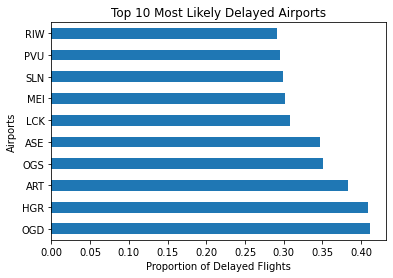

In [8]:
delays = df[df["DEP_DEL15"]==1]["ORIGIN"].value_counts()
total = df["ORIGIN"].value_counts()
proportion = (delays / total).sort_values(ascending = False)
ax = proportion.head(10).plot.barh()
ax.set(ylabel='Airports', xlabel='Proportion of Delayed Flights', title="Top 10 Most Likely Delayed Airports")

Now let's see which airports have the most delays overall.

[Text(17.200000000000003, 0.5, 'Airports'),
 Text(0.5, 17.200000000000003, 'Count of Delayed Flights'),
 Text(0.5, 1.0, 'Top 10 Most Delayed Airports')]

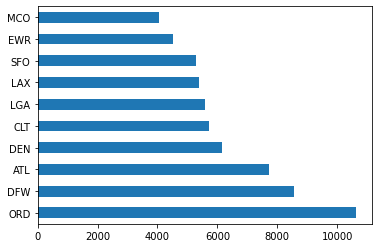

In [9]:
delays.head(10).plot.barh()
ax.set(ylabel='Airports', xlabel='Count of Delayed Flights', title="Top 10 Most Delayed Airports")

It's not much of a surprise that these busy airports have lots of delays. Lots of flights mean a higher quantity of delays. Still, it does seem that ORD (Chicago O'Hare) has more delays than usual for it's busy counter-airports.

### Time of Day for Delays

Let's see if time of day has any association with delayed flights.

[Text(0, 0.5, 'Time Block'),
 Text(0.5, 0, 'Proportion of Delayed Flights'),
 Text(0.5, 1.0, 'Delayed Flights by Time of Day')]

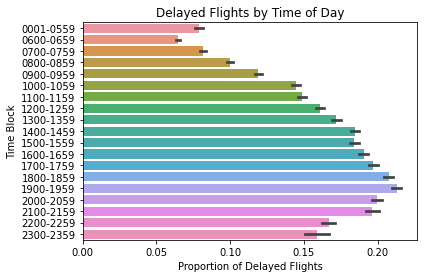

In [10]:
ax = sns.barplot(x="DEP_DEL15", y="DEP_TIME_BLK", data=df.sort_values('DEP_TIME_BLK'))
ax.set(ylabel='Time Block', xlabel='Proportion of Delayed Flights', title="Delayed Flights by Time of Day")

It seems that flights are less likely to be delayed in the morning and more likely to be delayed into the afternoon and peaking in the early evening. Because flights in the afternoon are using airplanes that have already flown once or twice earlier in the day, this graph makes sense. The risk of a flight delay increases with each previous flight during the day.

# Preparing for Training

Now we'll prepare our data one last time before training the model.

In [11]:
cols_to_keep = [
    "DAY_OF_WEEK",
    "OP_CARRIER",
    "ORIGIN",
    "DEP_DEL15",
    "DEP_TIME_BLK",
    "DISTANCE"
]
df = df[cols_to_keep]
df.head()

,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEP_DEL15,DEP_TIME_BLK,DISTANCE
0,2,9E,GNV,0.0,0600-0659,300.0
1,2,9E,MSP,0.0,1400-1459,596.0
2,2,9E,DTW,0.0,1200-1259,229.0
3,2,9E,TLH,0.0,1500-1559,223.0
4,2,9E,ATL,0.0,1900-1959,579.0


Let's split the data into train, test, and validation sets.

In [12]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

745747 train examples
186437 validation examples
233047 test examples


Now, we'll convert the pandas dataset into a dataset that tensorflow can use. This allows us to use feature columns.

In [14]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('DEP_DEL15')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(df, batch_size=batch_size)
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Understand the Input

Let's the check the format of the data in the input pipeline.

In [16]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of origins:', feature_batch['ORIGIN'])
  print('A batch of delayed flights:', label_batch )

Every feature: ['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEP_TIME_BLK', 'DISTANCE']
A batch of origins: tf.Tensor([b'DCA' b'LGA' b'DCA' b'SDF' b'JAX'], shape=(5,), dtype=string)
A batch of delayed flights: tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


Now we'll convert the categorical variables in the data to [one-hot](https://en.wikipedia.org/wiki/One-hot) tensors so tensorflow can make better use of the data.

In [20]:
example_batch = next(iter(train_ds))[0]

# utility function for testing, remove before flight
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

Now we'll construct feature columns that we'll use to pass into the model-building process. We'll also build a feature layer.

In [31]:
feature_columns = []

# adding numeric columns
distance = tf.feature_column.numeric_column("DISTANCE")
feature_columns.append(distance)

# adding categorical columns
origin = tf.feature_column.categorical_column_with_vocabulary_list(
      "ORIGIN", pd.unique(df.ORIGIN))
origin_one_hot = tf.feature_column.indicator_column(origin)
feature_columns.append(origin_one_hot)

carrier = tf.feature_column.categorical_column_with_vocabulary_list(
      "OP_CARRIER", pd.unique(df.OP_CARRIER))
carrier_one_hot = tf.feature_column.indicator_column(carrier)
feature_columns.append(carrier_one_hot)

time_blk = tf.feature_column.categorical_column_with_vocabulary_list(
      "DEP_TIME_BLK", pd.unique(df.DEP_TIME_BLK))
time_blk_one_hot = tf.feature_column.indicator_column(time_blk)
feature_columns.append(time_blk_one_hot)

day_of_week = tf.feature_column.categorical_column_with_vocabulary_list(
      "DAY_OF_WEEK", pd.unique(df.DAY_OF_WEEK))
day_of_week_one_hot = tf.feature_column.indicator_column(day_of_week)
feature_columns.append(day_of_week_one_hot)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Now, we'll set our batch size and prepare our datasets.

In [32]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Train the Model

In [33]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Train for 23305 steps, validate for 5827 steps
Epoch 1/5
23305/23305 [==============================] - 119s 5ms/step - loss: 0.4531 - accuracy: 0.8434 - val_loss: 0.4180 - val_accuracy: 0.8454
Epoch 2/5
23305/23305 [==============================] - 116s 5ms/step - loss: 0.4201 - accuracy: 0.8458 - val_loss: 0.4170 - val_accuracy: 0.8454
Epoch 3/5
23305/23305 [==============================] - 121s 5ms/step - loss: 0.4192 - accuracy: 0.8458 - val_loss: 0.4187 - val_accuracy: 0.8454
Epoch 4/5
23305/23305 [==============================] - 120s 5ms/step - loss: 0.4184 - accuracy: 0.8458 - val_loss: 0.4184 - val_accuracy: 0.8454
Epoch 5/5
23305/23305 [==============================] - 130s 6ms/step - loss: 0.4177 - accuracy: 0.8458 - val_loss: 0.4173 - val_accuracy: 0.8454


In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Train for 23305 steps, validate for 5827 steps
Epoch 1/5
23305/23305 [==============================] - 122s 5ms/step - loss: 0.4259 - accuracy: 0.8458 - val_loss: 0.4263 - val_accuracy: 0.8454
Epoch 2/5
23305/23305 [==============================] - 122s 5ms/step - loss: 0.4195 - accuracy: 0.8458 - val_loss: 0.4234 - val_accuracy: 0.8454
Epoch 3/5
23305/23305 [==============================] - 124s 5ms/step - loss: 0.4189 - accuracy: 0.8458 - val_loss: 0.4183 - val_accuracy: 0.8454
Epoch 4/5
 9833/23305 [===========>..................] - ETA: 1:03 - loss: 0.4196 - accuracy: 0.8455